In [7]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from ase.io import read
from qtpyt.basis import Basis

In [8]:
def prepare_leads_matrices(
    H_kMM, S_kMM, size, offset=(0.0, 0.0, 0.0), direction="x", align=None
):
    """Prepare input matrices for PrincipalLayer.
    
    Args:
        basis : basis function descriptor.
        H_kMM : Hamiltonian matrices in k-space.
        S_kMM : Overlap matrices in k-space.
        size, offset : Monkhorst-Pack used to sample Brillouin Zone.
    """

    kpts = monkhorst_pack(size, offset)
    print("kpts",kpts)
    if kpts.shape[0] > H_kMM.shape[0]:
        # Switch to irreducible k-points
        kpts = apply_inversion_symm(kpts)[0]
    print("kpts2",kpts)
    kpts_p, kpts_t = build_partial_kpts(size, offset, direction)
    print("kptsP,kpts_t",kpts_p,kpts_t)
    p_dir = "xyz".index(direction)

    R = [0, 0, 0]
    H_kii = partial_bloch_sum(H_kMM, kpts, R, kpts_p, kpts_t)
    S_kii = partial_bloch_sum(S_kMM, kpts, R, kpts_p, kpts_t)

    R[p_dir] = 1
    H_kij = partial_bloch_sum(H_kMM, kpts, R, kpts_p, kpts_t)
    S_kij = partial_bloch_sum(S_kMM, kpts, R, kpts_p, kpts_t)

    if align is not None:
        align_orbitals(kpts_t, H_kii, S_kii, H_kij, S_kij, align)
    # remove_pbc(basis, H_kij, direction)
    # remove_pbc(basis, S_kij, direction)

    return kpts_t, H_kii, S_kii, H_kij, S_kij

In [9]:
GPWDEVICEDIR = 'dft/device/'
GPWLEADSDIR = 'dft/leads_bulk/'

leads_path = Path(GPWLEADSDIR)
device_path = Path(GPWDEVICEDIR)
basis = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}
leads_atoms = read(leads_path / 'leads.traj')
leads_basis = Basis.from_dictionary(leads_atoms, basis)
device_atoms = read(device_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis)
H_leads_dft, S_leads_dft = np.load(leads_path / 'hs_leads_k.npy')
H_device_dft, S_device_dft = np.load(device_path/'hs_cc_k.npy')

In [10]:
from qtpyt.surface.tools import prepare_leads_matrices
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_dft, S_leads_dft, (5, 1, 1), align=(0, H_device_dft[0, 0, 0]))

In [11]:
from qtpyt.tools import remove_pbc, rotate_couplings
remove_pbc(device_basis, H_device_dft)
print(H_device_dft.shape)

(1, 1368, 1368)


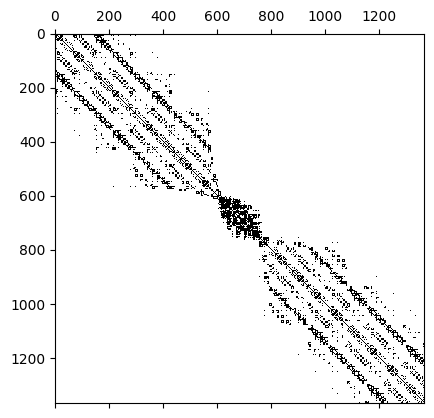

In [12]:
plt.spy(H_device_dft[0],precision=0.1)

In [13]:

from qtpyt.surface.principallayer import PrincipalSelfEnergy
remove_pbc(device_basis, S_device_dft)

Nr = (1, 1, 1)

self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr,
                            id='right')
h_ij = self_energy[0].h_ij


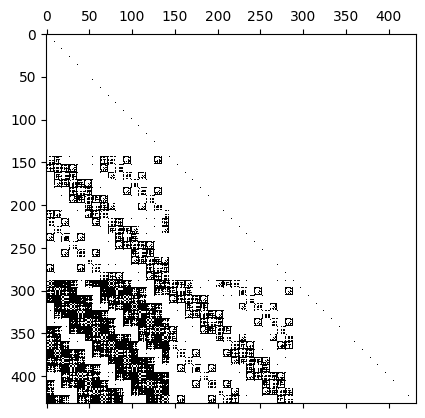

In [15]:
h_ij.shape
plt.spy(h_ij,precision=0.001)

In [16]:
from qtpyt.block_tridiag import graph_partition, greenfunction
#from qtpyt.parallel.egrid import GridDesc
nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_device_dft[0],
                                              len(leads_atoms.repeat(Nr)))


hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_device_dft[0], S_device_dft[0])

de = 0.3
energies = np.arange(-2., 2. + de / 2., de).round(7)
#gd = GridDesc(en#ergies, 1)
eta = 1e-3



In [19]:
gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                    #  solver='coupling',
                                    solver='dyson',
                                    eta=eta)

T = np.empty(energies.size)

for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)

#T = gd.gather_energies(T)

In [25]:
dataref = np.loadtxt("ET_hs_reference.dat")

In [28]:
dataref.shape

(700, 2)

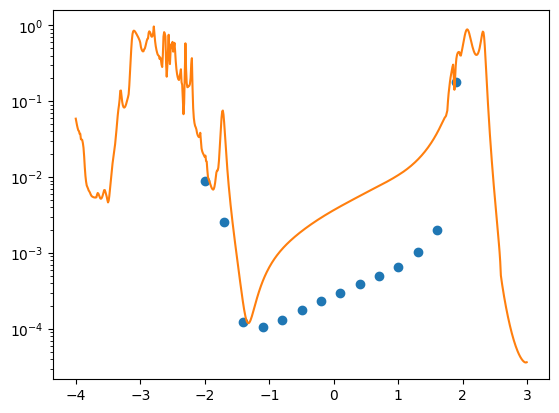

In [31]:
plt.plot(energies,T,'o')
plt.plot(dataref[:,0],dataref[:,1])
plt.yscale("log")

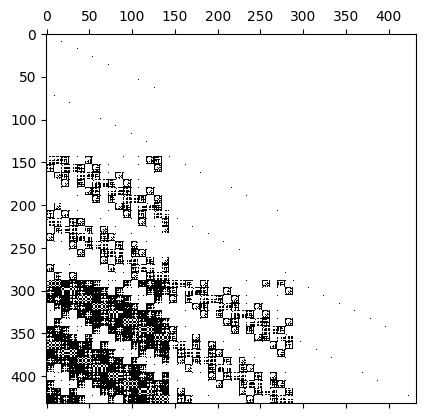

In [32]:
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)
h_ij.shape
plt.spy(h_ij,precision=0.001)

In [33]:
gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                    #  solver='coupling',
                                    solver='dyson',
                                    eta=eta)

T_rot = np.empty(energies.size)

for e, energy in enumerate(energies):
    T_rot[e] = gf.get_transmission(energy)

#T = gd.gather_energies(T)


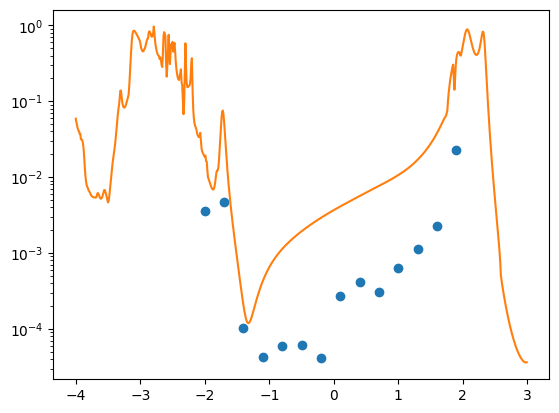

In [34]:
plt.plot(energies,T_rot,'o')
plt.plot(dataref[:,0],dataref[:,1])
plt.yscale("log")